In [71]:
import h5py
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from pylab import *
from numpy.fft import rfft,fft
from scipy.signal import spectrogram

In [72]:
from scipy.signal import butter, lfilter, filtfilt, iirnotch

def iir_notch(data, fs, frequency, quality=15., axis=-1):

    norm_freq = frequency/(fs/2)
    b, a = iirnotch(norm_freq, quality)
    y = filtfilt(b, a, data, padlen=0, axis=axis)
    return y

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=4, axis=-1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, padlen=0, axis=axis)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5, axis=-1):
    nyq = fs * 0.5
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, padlen=0, axis=axis)
    return y

def frequency_domain(data, time):
    x= np.array(data)
    dt = time[1] - time[0]
    N = len(x)
    T = N * dt
    xf = fft(x - x.mean())
    Sxx = 2 * dt ** 2 / T * (xf * xf.conj())
    Sxx = Sxx[:int(len(x) / 2)]
    df = 1 / T
    fNQ = 1 / dt / 2
    faxis = np.arange(0,fNQ,df)[:len(Sxx)]
    return faxis, Sxx.real

lfp_bands = {"beta": (12, 30), "gamma": (30, 80), "theta": (4, 12)}

In [73]:
f=h5py.File("C:\\Users\\sinha\\Dropbox\\CPLab\\cpl data\\20230623_dk1_BW_context_day1.mat")
channels = list(sorted(f.keys()))
print(channels)

['V20230623_dk1_BW_context_day1_Ch1', 'V20230623_dk1_BW_context_day1_Ch2', 'V20230623_dk1_BW_context_day1_Ch29', 'V20230623_dk1_BW_context_day1_Ch3', 'V20230623_dk1_BW_context_day1_Ch31', 'V20230623_dk1_BW_context_day1_Ch4', 'V20230623_dk1_BW_context_day1_Ch5', 'V20230623_dk1_BW_context_day1_Ch6', 'V20230623_dk1_BW_context_day1_Ch8', 'file']


In [74]:
channel_dict = {
    channel: (
        "LFP_AoN_1" if channel.endswith("_Ch1") else
        "LFP_AoN_2" if channel.endswith("_Ch2") else
        "LFP_AoN_3" if channel.endswith("_Ch3") else
        "LFP_VHC_1" if channel.endswith("_Ch4") else
        "LFP_VHC_2" if channel.endswith("_Ch5") else
        "LFP_VHC_3" if channel.endswith("_Ch6") else
        "reference" if channel.endswith("_Ch8") else
        "keyboard" if channel.endswith("_Ch31") else
        "Unknown"
    )
    for channel in channels
}

print(channel_dict)

{'V20230623_dk1_BW_context_day1_Ch1': 'LFP_AoN_1', 'V20230623_dk1_BW_context_day1_Ch2': 'LFP_AoN_2', 'V20230623_dk1_BW_context_day1_Ch29': 'Unknown', 'V20230623_dk1_BW_context_day1_Ch3': 'LFP_AoN_3', 'V20230623_dk1_BW_context_day1_Ch31': 'keyboard', 'V20230623_dk1_BW_context_day1_Ch4': 'LFP_VHC_1', 'V20230623_dk1_BW_context_day1_Ch5': 'LFP_VHC_2', 'V20230623_dk1_BW_context_day1_Ch6': 'LFP_VHC_3', 'V20230623_dk1_BW_context_day1_Ch8': 'reference', 'file': 'Unknown'}


## Lets try to get the event data first

In [78]:
events=f['V20230623_dk1_BW_context_day1_Ch1']
print(events.keys())
sampling_rate = int(1/events['interval'][0][0])
print(sampling_rate)    

<KeysViewHDF5 ['comment', 'interval', 'length', 'offset', 'scale', 'start', 'times', 'title', 'units', 'values']>
2000


In [53]:
events_codes=np.array(events['codes'][0])
events_times=np.array(events['times'][0])
print(events_codes)
print(events_times)

[119  49  98  48  49  98  49 119  49 119  49  98  49 119  49  98  48  49
  98  48  49 119  49 119  49 119  49 119  49  98  49  98  49 119  49  98
  49 119  49 119  49  98  49  98  49  52 119  49 119  49  98  49 119  49
  98  49  98  49  98  49 119  49 119  49  98  49 119  49  98  49 119  49
  98  49 119  49  98  49  98  49 119  49  98  49]
[  87.728145   89.388145  131.73415   135.694145  147.02415   178.53615
  180.194145  213.514145  215.212145  238.44215   243.01015   275.288145
  277.258145  311.47415   315.114145  334.270145  337.10015   341.43015
  363.318145  366.19815   370.24815   389.788145  392.34815   411.14215
  415.57215   445.41615   447.55615   489.844145  491.62415   530.040145
  532.22815   552.812145  554.432145  577.81615   579.00615   601.076145
  602.72615   623.61615   625.646145  648.926145  650.47615   714.126145
  718.006145  740.55215   741.872145  741.92215   773.84015   779.658145
  799.55015   801.990145  822.302145  825.112145  850.532145  856.97215
  883

In [54]:
first_event=events_times[0]
print(first_event)

87.728145


In [55]:
for i in channel_dict.keys():
    if "AoN" in channel_dict[i]:
        AoN = f[i]
        AoN_data=np.array(AoN['values']).flatten()
        time_AoN = np.array(AoN['times']).flatten()

C:\Users\sinha\AppData\Local\Temp/ipykernel_12388/1516863714.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  AoN_data=np.array(AoN['values']).flatten()
C:\Users\sinha\AppData\Local\Temp/ipykernel_12388/1516863714.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  time_AoN = np.array(AoN['times']).flatten()


In [56]:
np.where(time_AoN>first_event)[0][0]

data_smol=AoN_data[np.where(time_AoN>first_event)[0][0]-30*2000:np.where(time_AoN>first_event)[0][0]]
time_smol=time_AoN[np.where(time_AoN>first_event)[0][0]-30*2000:np.where(time_AoN>first_event)[0][0]]
plot(time_AoN,AoN_data)
plot(time_smol,data_smol)
plot(events_times[0],0,'ro')

In [57]:
mean=np.mean(data_smol)
std=np.std(data_smol)
print(mean,std)

AoN_data_norm=(AoN_data-mean)/std

-0.0008895034790039062 0.1461356582990583


In [59]:
plot(time_AoN,AoN_data_norm)
plot(time_smol,data_smol)
plot(events_times[0],0,'ro')

Now we want to extract the data 2-5 seconds after the door opened

In [60]:
events_concat=np.vstack((events_times,events_codes)).T
print(events_concat)

[[  87.728145  119.      ]
 [  89.388145   49.      ]
 [ 131.73415    98.      ]
 [ 135.694145   48.      ]
 [ 147.02415    49.      ]
 [ 178.53615    98.      ]
 [ 180.194145   49.      ]
 [ 213.514145  119.      ]
 [ 215.212145   49.      ]
 [ 238.44215   119.      ]
 [ 243.01015    49.      ]
 [ 275.288145   98.      ]
 [ 277.258145   49.      ]
 [ 311.47415   119.      ]
 [ 315.114145   49.      ]
 [ 334.270145   98.      ]
 [ 337.10015    48.      ]
 [ 341.43015    49.      ]
 [ 363.318145   98.      ]
 [ 366.19815    48.      ]
 [ 370.24815    49.      ]
 [ 389.788145  119.      ]
 [ 392.34815    49.      ]
 [ 411.14215   119.      ]
 [ 415.57215    49.      ]
 [ 445.41615   119.      ]
 [ 447.55615    49.      ]
 [ 489.844145  119.      ]
 [ 491.62415    49.      ]
 [ 530.040145   98.      ]
 [ 532.22815    49.      ]
 [ 552.812145   98.      ]
 [ 554.432145   49.      ]
 [ 577.81615   119.      ]
 [ 579.00615    49.      ]
 [ 601.076145   98.      ]
 [ 602.72615    49.      ]
 

In [ ]:
white_trials=[]
black_trials=[]
for eventsi in events_concat:
    if eventsi[1]==119:
        white_trials.append(eventsi[0])
    elif eventsi[1]==98:
        black_trials.append(eventsi[0])

In [61]:
# Initialize list to store epochs
epochs = []

# Initialize variables to track the start of an epoch
start_index = None

# Iterate through events_concat
for i, event in enumerate(events_concat):
    if event[1] == 119 or event[1] == 98:
        if start_index is None:
            # Start a new epoch
            start_index = i
        else:
            # End the current epoch
            end_index = i
            epoch = events_concat[start_index:end_index]
            epochs.append(epoch)
            start_index = None

# Print the epochs
for epoch in epochs:
    print(epoch)

[[ 87.728145 119.      ]
 [ 89.388145  49.      ]]
[[178.53615   98.      ]
 [180.194145  49.      ]]
[[238.44215 119.     ]
 [243.01015  49.     ]]
[[311.47415  119.      ]
 [315.114145  49.      ]]
[[363.318145  98.      ]
 [366.19815   48.      ]
 [370.24815   49.      ]]
[[411.14215 119.     ]
 [415.57215  49.     ]]
[[489.844145 119.      ]
 [491.62415   49.      ]]
[[552.812145  98.      ]
 [554.432145  49.      ]]
[[601.076145  98.      ]
 [602.72615   49.      ]]
[[648.926145 119.      ]
 [650.47615   49.      ]]
[[740.55215   98.      ]
 [741.872145  49.      ]
 [741.92215   52.      ]]
[[799.55015  119.      ]
 [801.990145  49.      ]]
[[850.532145 119.      ]
 [856.97215   49.      ]]
[[908.222145  98.      ]
 [911.16215   49.      ]]
[[967.928145 119.      ]
 [969.698145  49.      ]]
[[1015.02215   98.     ]
 [1019.22215   49.     ]]
[[1129.95215   98.     ]
 [1131.94015   49.     ]]
[[1182.916145   98.      ]
 [1184.836145   49.      ]]
[[1232.070145   98.      ]
 [1234.00

In [ ]:
# Initialize empty lists to store trial data
white_trials = []
correct_in_white_after = []
incorrect_in_white_after = []
correct_in_white_before = []
incorrect_in_white_before = []
black_trials = []
correct_in_black_after = []
incorrect_in_black_after = []
correct_in_black_before = []
incorrect_in_black_before = []

# Iterate through each epoch
for epochi in epochs:
    trial_timestamp = epochi[0][0]  # Get the timestamp of the trial
    print(trial_timestamp)
    
    if epochi[0][1] == 119:  # Check if the trial is a white trial
        trial_index = np.where(time_AoN > trial_timestamp)[0][0]  # Find the index of the trial start
        data_trial = AoN_data_norm[trial_index:trial_index + 5 * 2000]  # Extract the trial data
        white_trials.append(data_trial)  # Append the trial data to white_trials
        
        # Iterate through the events within the epoch
        for diggingi in range(1, epochi.shape[0]):
            if epochi[diggingi][1] == 49:  # Check if the event is a correct dig
                dig_timestamp = epochi[diggingi][0]  # Get the timestamp of the dig
                dig_index = np.where(time_AoN > dig_timestamp)[0][0]  # Find the index of the dig
                
                # Extract data before and after the dig
                data_dig_after = AoN_data_norm[dig_index:dig_index + 5 * 2000]
                data_dig_before = AoN_data_norm[dig_index - 5 * 2000:dig_index]
                
                # Append the data to the respective lists
                correct_in_white_before.append(data_dig_before)
                correct_in_white_after.append(data_dig_after)
            
            elif epochi[diggingi][1] == 48:  # Check if the event is an incorrect dig
                dig_timestamp = epochi[diggingi][0]  # Get the timestamp of the dig
                dig_index = np.where(time_AoN > dig_timestamp)[0][0]  # Find the index of the dig
                
                # Extract data before and after the dig
                data_dig_after = AoN_data_norm[dig_index:dig_index + 5 * 2000]
                incorrect_in_white_after.append(data_dig_after)
                
                data_dig_before = AoN_data_norm[dig_index - 5 * 2000:dig_index]
                incorrect_in_white_before.append(data_dig_before)
    
    elif epochi[0][1] == 98:  # Check if the trial is a black trial
        trial_index = np.where(time_AoN > trial_timestamp)[0][0]  # Find the index of the trial start
        data_trial = AoN_data_norm[trial_index:trial_index + 5 * 2000]  # Extract the trial data
        black_trials.append(data_trial)  # Append the trial data to black_trials
        
        # Iterate through the events within the epoch
        for diggingi in range(1, epochi.shape[0]):
            if epochi[diggingi][1] == 49:  # Check if the event is a correct dig
                dig_timestamp = epochi[diggingi][0]  # Get the timestamp of the dig
                dig_index = np.where(time_AoN > dig_timestamp)[0][0]  # Find the index of the dig
                
                # Extract data before and after the dig
                data_dig_after = AoN_data_norm[dig_index:dig_index + 5 * 2000]
                correct_in_black_after.append(data_dig_after)
                
                data_dig_before = AoN_data_norm[dig_index - 5 * 2000:dig_index]
                correct_in_black_before.append(data_dig_before)
            
            elif epochi[diggingi][1] == 48:  # Check if the event is an incorrect dig
                dig_timestamp = epochi[diggingi][0]  # Get the timestamp of the dig
                dig_index = np.where(time_AoN > dig_timestamp)[0][0]  # Find the index of the dig
                
                # Extract data before and after the dig
                data_dig_after = AoN_data_norm[dig_index:dig_index + 5 * 2000]
                incorrect_in_black_after.append(data_dig_after)
                
                data_dig_before = AoN_data_norm[dig_index - 5 * 2000:dig_index]
                incorrect_in_black_before.append(data_dig_before)

# Convert lists to NumPy arrays
white_trials = np.array(white_trials)
black_trials = np.array(black_trials)

correct_in_white_before = np.array(correct_in_white_before)
incorrect_in_white_before = np.array(incorrect_in_white_before)
correct_in_white_after = np.array(correct_in_white_after)
incorrect_in_white_after = np.array(incorrect_in_white_after)

correct_in_black_before = np.array(correct_in_black_before)
incorrect_in_black_before = np.array(incorrect_in_black_before)
correct_in_black_after = np.array(correct_in_black_after)
incorrect_in_black_after = np.array(incorrect_in_black_after)

# Print the shapes of the arrays
print("White Trials Shape:", white_trials.shape)
print("Black Trials Shape:", black_trials.shape)

87.728145
178.53615
238.44214999999997
311.47414999999995
363.31814499999996
411.14214999999996
489.84414499999997
552.812145
601.076145
648.9261449999999
740.55215
799.5501499999999
850.5321449999999
908.222145
967.9281449999999
1015.0221499999999
1129.9521499999998
1182.916145
1232.070145
1293.9701449999998
White Trials Shape: (10, 10000)
Black Trials Shape: (10, 10000)


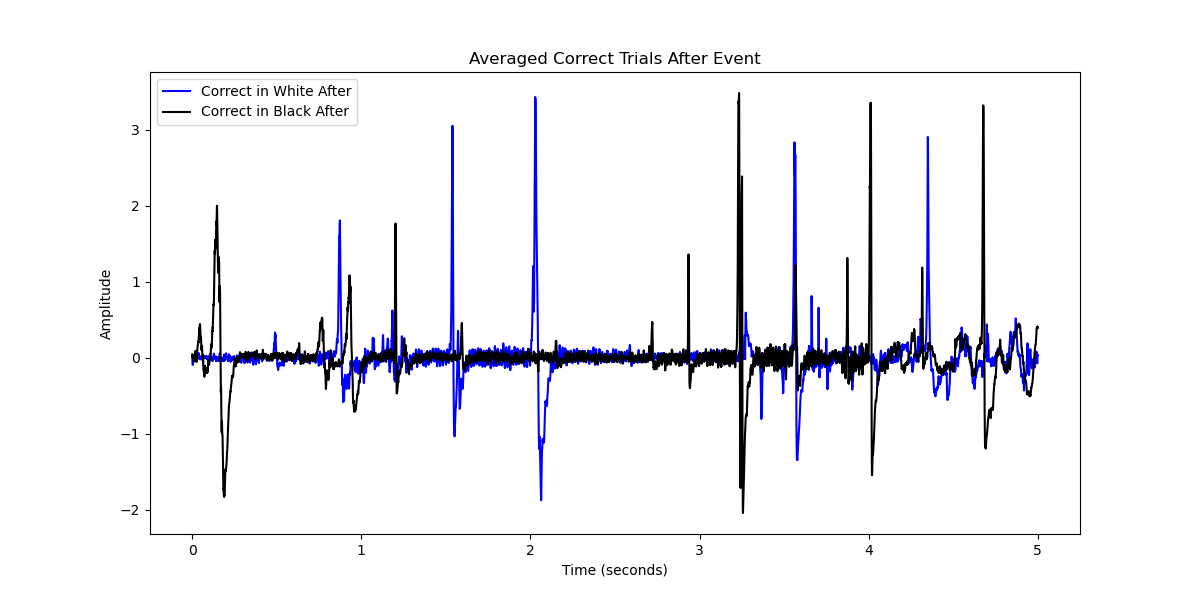

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming correct_in_white_after and correct_in_black_after are already defined as NumPy arrays

# Calculate the average of each array
avg_correct_in_white_after = np.mean(correct_in_white_after, axis=0)
avg_correct_in_black_after = np.mean(correct_in_black_after, axis=0)

# Plot the averaged data
plt.figure(figsize=(12, 6))

time_axis = np.linspace(0, 5, avg_correct_in_white_after.shape[0])  # 5 seconds before the event

plt.plot(time_axis,avg_correct_in_white_after, label='Correct in White After', color='blue')
plt.plot(time_axis,avg_correct_in_black_after, label='Correct in Black After', color='black')

plt.title('Averaged Correct Trials After Event')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

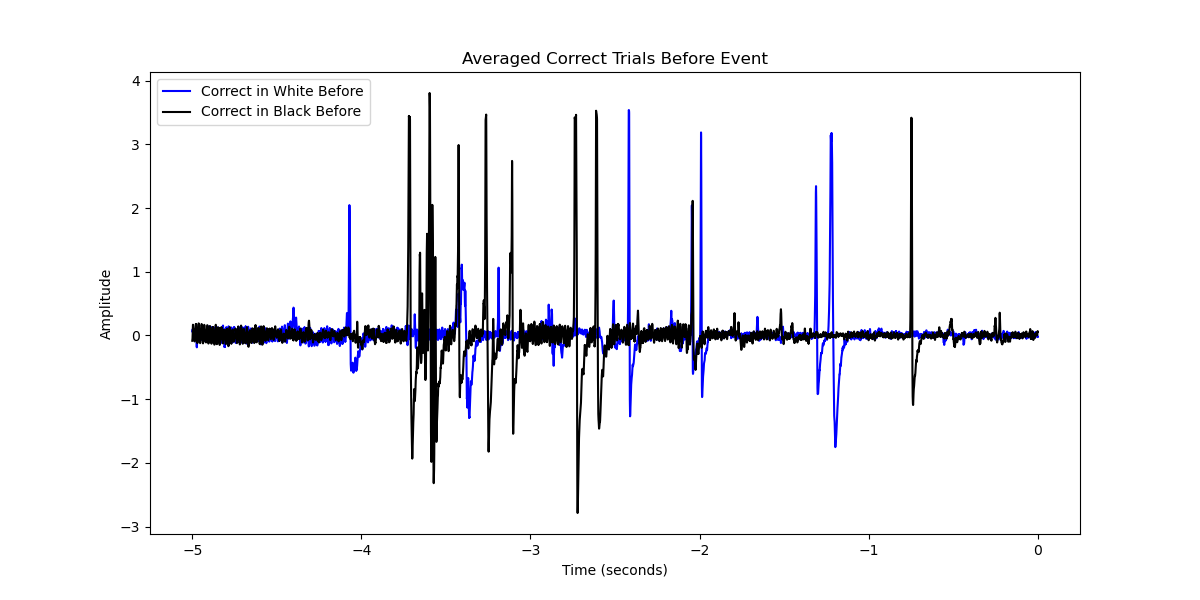

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Calculate the average of each array
avg_correct_in_white_before = np.mean(correct_in_white_before, axis=0)
avg_correct_in_black_before = np.mean(correct_in_black_before, axis=0)

# Create a time axis in seconds (assuming a sampling rate of 2000 Hz)
sampling_rate = 2000  # samples per second
time_axis = np.linspace(-5, 0, avg_correct_in_white_before.shape[0])  # 5 seconds before the event

# Plot the averaged data
plt.figure(figsize=(12, 6))

plt.plot(time_axis, avg_correct_in_white_before, label='Correct in White Before', color='blue')
plt.plot(time_axis, avg_correct_in_black_before, label='Correct in Black Before', color='black')

plt.title('Averaged Correct Trials Before Event')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Trying to extract the bands before doing the lowpass and resampling things

dict_keys(['beta', 'gamma', 'theta'])
(12, 30)


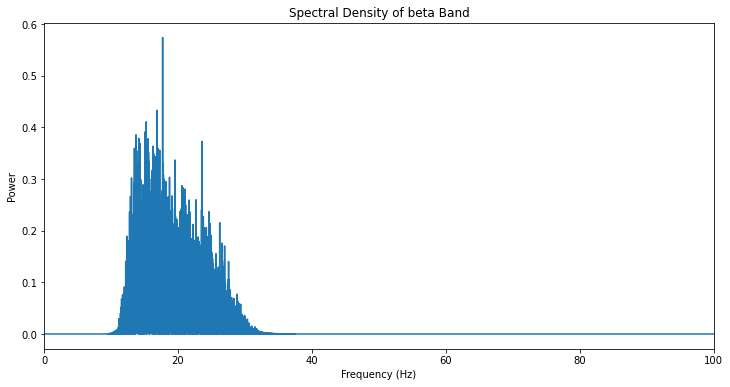

(30, 80)


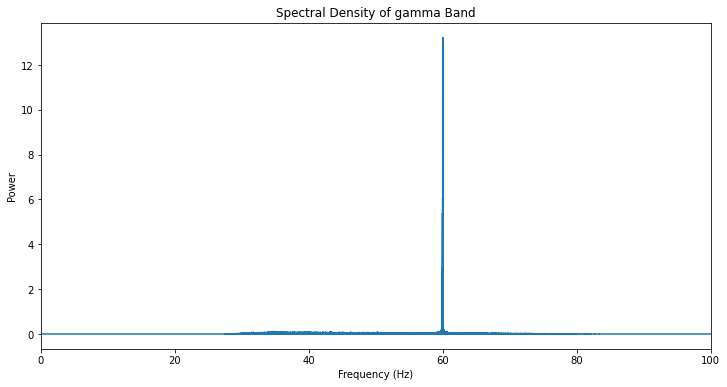

(4, 12)


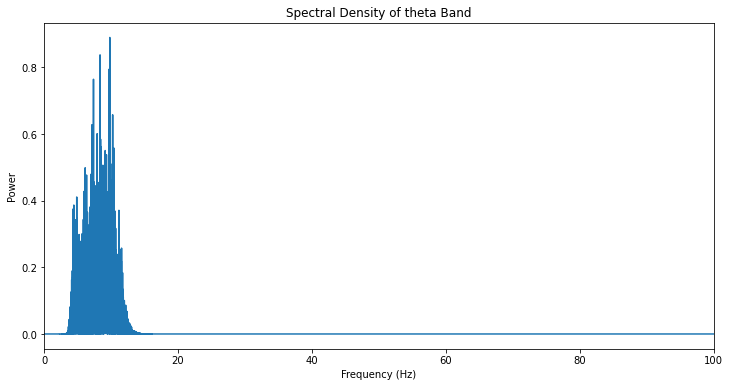

In [70]:
print(lfp_bands.keys())
bands_data_dict={}
for bandsi in lfp_bands.keys():
    band=lfp_bands[bandsi]
    print(band)

    b,a=butter(4, band, fs=2000, btype='band')
    data_filtered=filtfilt(b,a,AoN_data_norm)
    bands_data_dict[bandsi]=data_filtered
    faxis, Sxx = frequency_domain(data_filtered, time_AoN)

    %matplotlib inline
    plt.figure(figsize=(12, 6))
    plt.plot(faxis, Sxx)
    plt.xlim(0, 100)
    plt.title(f"Spectral Density of {bandsi} Band")
    
    plt.xlabel("Frequency (Hz)")

    plt.ylabel("Power")
    plt.show()


In [5]:
AoN_dict={}
for i in channel_dict.keys():
    if "AoN" in channel_dict[i]:
        AoN = f[i]
        AoN_data=np.array(AoN['values']).flatten()
        time_AoN = np.array(AoN['times']).flatten()

        

        low_pass = butter_lowpass_filter(AoN_data, 500, 2000)

        # Calculate the new number of samples
        original_sample_rate = 2000  # Original sample rate in Hz
        new_sample_rate = 1000  # Desired sample rate in Hz
        num_samples = len(low_pass)
        duration = num_samples / original_sample_rate  # Duration in seconds
        new_num_samples = int(duration * new_sample_rate)

        filtered_data_resample=scipy.signal.resample(low_pass, new_num_samples)
        time_resample = np.linspace(time_AoN[0], time_AoN[-1], new_num_samples)

        filtered_data_resample_highpass = butter_highpass_filter(filtered_data_resample, 1, 1000)
        filtered_data_resample_highpass_notch = iir_notch(filtered_data_resample_highpass, 1000, 60, quality=15.)


Apparently we just need to save the electrode datas as NPY files. We dont need to merge them together

We need to extract data around time events

Getting the start of the first trial time point

Lets get the mean and std deviation of the small data and then subtract that with the big data